## Import Required Libraries
استيراد المكتبات المطلوبة

In [1]:
# 0) Imports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error


## Load the Dataset
تحميل مجموعة البيانات

In [2]:
# 1) Load data + keep ids + target + n_train
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test  = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

n_train = train.shape[0]
test_ids = test['Id'].copy()
y = train['SalePrice'].copy()             
y_log = np.log1p(y)                        # الهدف لوغاريتمي

# drop id/target from feature tables
train = train.drop(columns=['Id','SalePrice'])
test  = test.drop(columns=['Id'])


In [3]:
# 2) Combine
all_data = pd.concat([train, test], axis=0, ignore_index=True)
print("Combined shape:", all_data.shape)


Combined shape: (2919, 79)


## Exploratory Data Analysis (EDA)
تحليل البيانات الاستكشافي

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [5]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


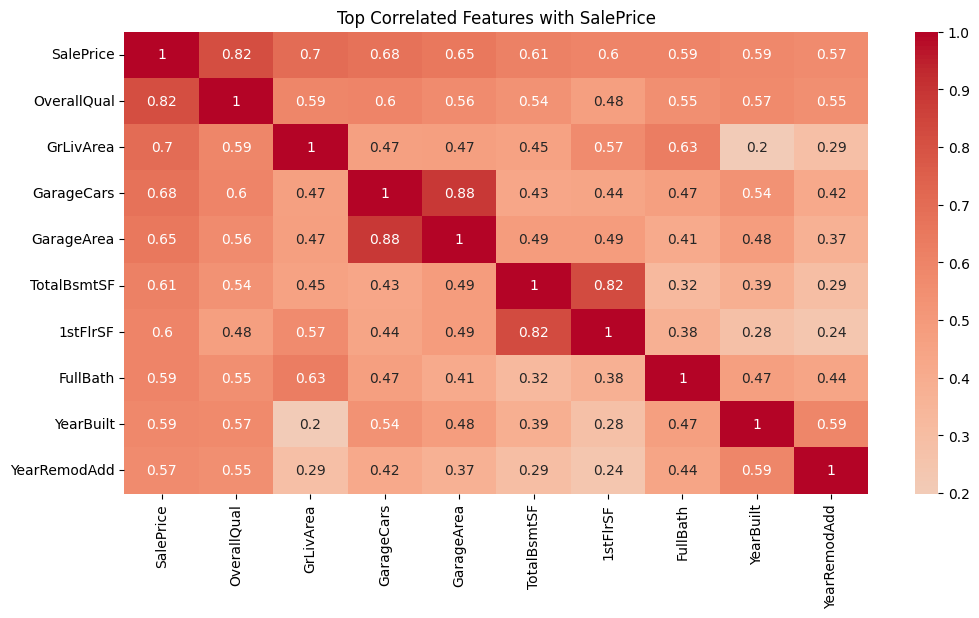

In [6]:
train_num = all_data.iloc[:n_train].select_dtypes(include=[np.number]).copy()
train_num['SalePrice'] = y_log
corr_matrix = train_num.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(12, 6))
sns.heatmap(train_num[top_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Top Correlated Features with SalePrice")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


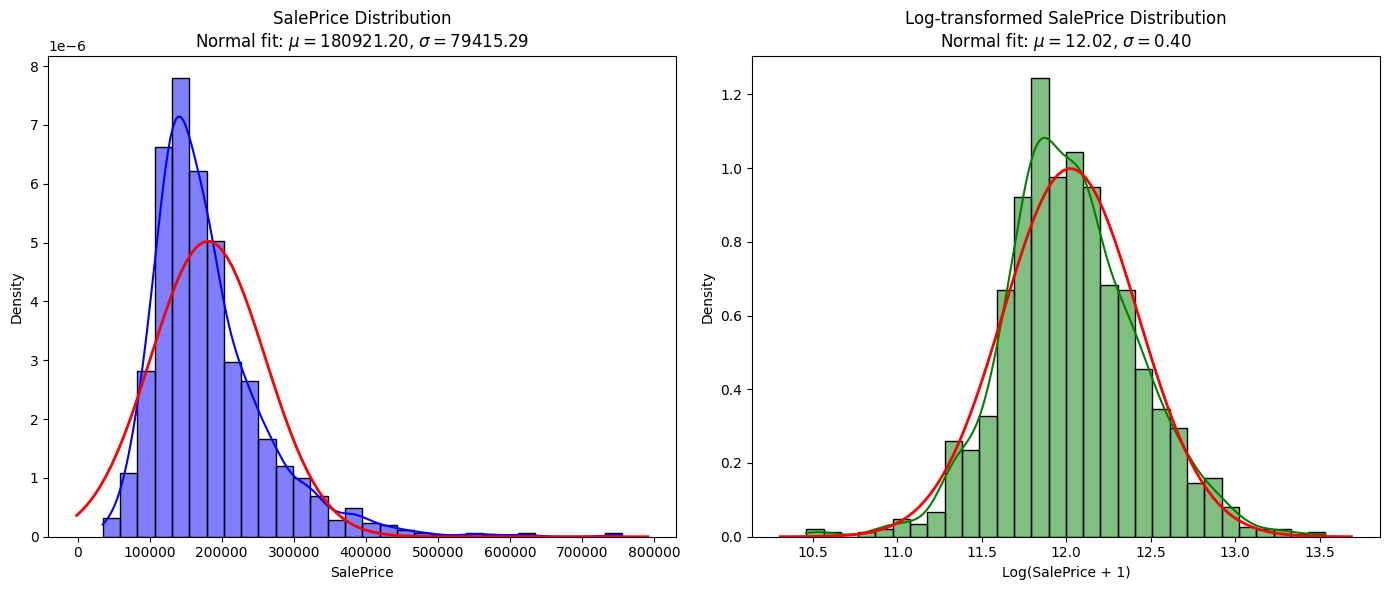

In [7]:
# تقدير معاملات التوزيع الطبيعي (المتوسط والانحراف المعياري) للبيانات الأصلية
(mu_orig, sigma_orig) = norm.fit(y)

# تقدير معاملات التوزيع الطبيعي للبيانات بعد اللوغاريتم
(mu_log, sigma_log) = norm.fit(y_log)

plt.figure(figsize=(14, 6))

# التوزيع الأصلي
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, stat="density", bins=30, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_orig, sigma_orig)
plt.plot(x, p, 'r', linewidth=2)
plt.title(f'SalePrice Distribution\nNormal fit: $\mu={mu_orig:.2f}$, $\sigma={sigma_orig:.2f}$')
plt.xlabel('SalePrice')
plt.ylabel('Density')

# التوزيع بعد اللوغاريتم
plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True, stat="density", bins=30, color='green')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_log, sigma_log)
plt.plot(x, p, 'r', linewidth=2)
plt.title(f'Log-transformed SalePrice Distribution\nNormal fit: $\mu={mu_log:.2f}$, $\sigma={sigma_log:.2f}$')
plt.xlabel('Log(SalePrice + 1)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [8]:
obj = all_data.isnull().sum()
for key,value in obj.items():
    if value > 0:
        print(key,",",value)

MSZoning , 4
LotFrontage , 486
Alley , 2721
Utilities , 2
Exterior1st , 1
Exterior2nd , 1
MasVnrType , 1766
MasVnrArea , 23
BsmtQual , 81
BsmtCond , 82
BsmtExposure , 82
BsmtFinType1 , 79
BsmtFinSF1 , 1
BsmtFinType2 , 80
BsmtFinSF2 , 1
BsmtUnfSF , 1
TotalBsmtSF , 1
Electrical , 1
BsmtFullBath , 2
BsmtHalfBath , 2
KitchenQual , 1
Functional , 2
FireplaceQu , 1420
GarageType , 157
GarageYrBlt , 159
GarageFinish , 159
GarageCars , 1
GarageArea , 1
GarageQual , 159
GarageCond , 159
PoolQC , 2909
Fence , 2348
MiscFeature , 2814
SaleType , 1


## Data Cleaning and Missing Value Treatment
تنظيف البيانات والتعامل مع القيم المفقودة

In [9]:
# 3) Missing-value strategy (منضبط وواضح)
# categorical: 'None' where NaN يعني عدم وجود الميزة
cat_none = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
            'PoolQC','Fence','MiscFeature','MasVnrType']

for c in cat_none:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna('None')

# numeric columns where NaN means 0 (لا توجد الميزة)
num_zero = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
for c in num_zero:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna(0)

# LotFrontage by neighborhood (median)
if 'LotFrontage' in all_data.columns:
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage']\
                                      .transform(lambda x: x.fillna(x.median()))

# small remaining categorical -> fill with mode
for c in ['MSZoning','Utilities','Functional','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

# final check
print("Missing values before final safety fill:", all_data.isnull().sum().sum())

all_data = all_data.fillna(0) # إذا كان في أي خانة في الجدول (DataFrame) فيها قيمة مفقودة، سيتم استبدالها بـ 0.
print("Missing values after safety fill:", all_data.isnull().sum().sum())


Missing values before final safety fill: 0
Missing values after safety fill: 0


In [10]:
def remove_outliers(train_df, y, all_data, n_train):
    # شروط القيم المتطرفة (بناءً على train_df أو all_data حتى لا نخلط)
    outlier_conditions = (
        (train_df['LotArea'] > 100000) |
        (train_df['GrLivArea'] > 4500) 
    )
    
    # بالإضافة إلى شرط quantile للقيمة الهدف SalePrice
    threshold = y.quantile(0.9970)
    price_condition = y > threshold
    
    # توحيد الشرط لحذف الصفوف التي تحقق أي شرط من القيم المتطرفة
    outliers = outlier_conditions | price_condition
    
    print(f"Number of outliers to remove: {outliers.sum()}")
    
    # حذف الصفوف من كل من train_df و y و all_data معاً لضمان التزامن
    train_df_clean = train_df.loc[~outliers].reset_index(drop=True)
    y_clean = y.loc[~outliers].reset_index(drop=True)
    
    # لتحديث all_data (الذي يحتوي train+test)، نحذف فقط الصفوف المقابلة في الجزء الأول (train)
    # يجب حذف نفس الصفوف من الجزء الخاص بـ train داخل all_data
    # ثم إعادة دمج مع test (التي تبدأ من index n_train)
    
    # تقسيم all_data إلى train و test أجزاء
    train_part = all_data.iloc[:n_train].copy()
    test_part = all_data.iloc[n_train:].copy()
    
    train_part_clean = train_part.loc[~outliers].reset_index(drop=True)
    
    # إعادة دمج مع test بدون تغيير
    all_data_clean = pd.concat([train_part_clean, test_part], ignore_index=True)
    
    # تحديث عدد عينات التدريب
    n_train_clean = train_part_clean.shape[0]
    
    return train_df_clean, y_clean, all_data_clean, n_train_clean

# الاستخدام:
train, y, all_data, n_train = remove_outliers(train, y, all_data, n_train)
y_log = np.log1p(y)


Number of outliers to remove: 11


## 

In [11]:
# 4) Feature engineering (اقتراحات قوية)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5*all_data['HalfBath'] +
                               all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath'])
all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

# أعمار / مؤشرات ثنائية
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['HasGarage'] = (all_data['GarageCars'] > 0).astype(int)
all_data['HasBasement'] = (all_data['TotalBsmtSF'] > 0).astype(int)


## Encoding Categorical Variables
تحويل الميزات الفئوية إلى عددية

In [12]:
# 5) Ordinal mappings (مهم: نستخدم 'None' string لأنه عوضناه سابقاً)
quality_map = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
exposure_map = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
fin_type_map = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}

ord_cols_q = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
              'FireplaceQu','GarageQual','GarageCond']
for c in ord_cols_q:
    if c in all_data.columns:
        all_data[c] = all_data[c].map(quality_map)

if 'BsmtExposure' in all_data.columns:
    all_data['BsmtExposure'] = all_data['BsmtExposure'].map(exposure_map)

for c in ['BsmtFinType1','BsmtFinType2']:
    if c in all_data.columns:
        all_data[c] = all_data[c].map(fin_type_map)


In [13]:
# 6) One-hot for remaining categorical (بعد تحويل ordinal أعلاه)
cat_cols = all_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns to one-hot:", len(cat_cols))

all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)
print("Shape after dummies:", all_data.shape)


Categorical columns to one-hot: 31
Shape after dummies: (2908, 226)


## Split Data
تقسيم البيانات

In [14]:
# 7) Split back to train/test
X_all = all_data.copy()
X = X_all.iloc[:n_train, :].reset_index(drop=True)
X_test = X_all.iloc[n_train:, :].reset_index(drop=True)
y_log = np.log1p(y)   # الهدف المعدل

print("X shape:", X.shape, "X_test shape:", X_test.shape)


X shape: (1449, 226) X_test shape: (1459, 226)


## Evaluate Model Performance
تقييم أداء النماذج

In [15]:
# 8) Baseline evaluation (cross-val) - دالة مساعدة
def rmse_cv(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    return np.sqrt(-scores)

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

for name, model in models.items():
    print("Evaluating:", name)
    scores = rmse_cv(model, X, y_log, cv=5)
    print(f"{name} RMSE CV mean: {scores.mean():.5f}, std: {scores.std():.5f}")
    print("-"*40)


Evaluating: LinearRegression
LinearRegression RMSE CV mean: 0.12122, std: 0.01155
----------------------------------------
Evaluating: DecisionTree
DecisionTree RMSE CV mean: 0.19599, std: 0.01016
----------------------------------------
Evaluating: RandomForest
RandomForest RMSE CV mean: 0.13406, std: 0.00683
----------------------------------------
Evaluating: XGBoost
XGBoost RMSE CV mean: 0.13279, std: 0.00542
----------------------------------------


## Train Models
تدريب النماذج

In [16]:
# 9) تدريب أفضل نموذج ( XGBoost ) 
X_tr, X_val, y_tr, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 3500,
    'learning_rate': 0.009,
    'max_depth': 5,
    'min_child_weight': 2,
    'colsample_bytree': 0.2,
    'subsample': 0.4,
    'random_state': 42,
    'n_jobs': -1  # استخدم كل أنوية المعالج لتسريع التدريب
}

model = XGBRegressor(**best_params)
model.fit(X_tr, y_tr)
preds_val = model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
print("Validation RMSE:", rmse_val)


Validation RMSE: 0.12158333407754256


## Make Predictions on Test Set
إجراء التنبؤات على مجموعة الاختبار

In [17]:
# 10) التنبؤ على مجموعة الاختبار وكتابة submission
test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())


     Id      SalePrice
0  1461  125591.765625
1  1462  161911.296875
2  1463  182970.109375
3  1464  192725.500000
4  1465  183835.031250
